In [ ]:
!pip install xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 MB 5.3 MB/s eta 0:00:00


In [ ]:
# Load datasets
matchups_2007 = pd.read_csv("matchups-2007.csv")
matchups_2008 = pd.read_csv("matchups-2008.csv")
matchups_2009 = pd.read_csv("matchups-2009.csv")

In [ ]:

# Combine training datasets
train_df = pd.concat([matchups_2007, matchups_2008], ignore_index=True)

In [ ]:

# Use 30% of 2009 data for testing
test_df, _ = train_test_split(matchups_2009, test_size=0.7, random_state=42)

In [ ]:

# Define selected features for model training (excluding 'game')
selected_features = ["season", "home_team", "away_team", "starting_min",
                     "home_0", "home_1", "home_2", "home_3", "home_4",
                     "away_0", "away_1", "away_2", "away_3", "away_4"]

In [ ]:
# Ensure 'outcome' column exists
if "outcome" not in train_df.columns or "outcome" not in test_df.columns:
    raise KeyError("The 'outcome' column is missing from the dataset.")

In [ ]:
# Convert categorical features into numerical values
categorical_cols = ["home_team", "away_team", "home_0", "home_1", "home_2", "home_3", "home_4", "away_0", "away_1", "away_2", "away_3", "away_4"]
label_encoders = {}

In [ ]:
for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str))
    test_df[col] = test_df[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
    label_encoders[col] = le

In [ ]:
# Define Features and Target
X_train = train_df[selected_features]
y_train = (train_df["outcome"] == 1).astype(int)
X_test = test_df[selected_features]
y_test = (test_df["outcome"] == 1).astype(int)

In [ ]:

# Scale only numerical features
numerical_cols = ["season", "starting_min"]
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])


<ipython-input-11-0429c12b7e07>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
<ipython-input-11-0429c12b7e07>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])


In [ ]:
# Initialize models
rf_model = RandomForestClassifier(n_estimators=200, max_depth=15, min_samples_split=5, random_state=42)
xgb_model = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, random_state=42, use_label_encoder=False, eval_metric='logloss')
dnn_model = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=500, random_state=42)

In [ ]:
# Train models
rf_model.fit(X_train, y_train)



RandomForestClassifier(max_depth=15, min_samples_split=5, n_estimators=200,
                       random_state=42)

In [ ]:
xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:47:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
dnn_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42)

In [ ]:
# Ensemble learning (Stacking models)
stacking_model = StackingClassifier(estimators=[('rf', rf_model), ('xgb', xgb_model), ('dnn', dnn_model)], final_estimator=LogisticRegression())
stacking_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:41:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:14:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:14:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:14:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

 

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(max_depth=15,
                                                       min_samples_split=5,
                                                       n_estimators=200,
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.8, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              featu...
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=6,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=200, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...)),
                               ('dnn',
                                MLPClassifier(hidden_layer_sizes=(128, 64),
                                              max_iter=500, random_state=42))],
                   final_estimator=LogisticRegression())

In [ ]:
# Evaluate models
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)
dnn_pred = dnn_model.predict(X_test)
stk_pred = stacking_model.predict(X_test)

rf_acc = accuracy_score(y_test, rf_pred)
xgb_acc = accuracy_score(y_test, xgb_pred)
dnn_acc = accuracy_score(y_test, dnn_pred)
stk_acc = accuracy_score(y_test, stk_pred)

print(f"Random Forest Accuracy: {rf_acc:.4f}")
print(f"XGBoost Accuracy: {xgb_acc:.4f}")
print(f"Deep Learning Accuracy: {dnn_acc:.4f}")
print(f"Stacking Model Accuracy: {stk_acc:.4f}")

Random Forest Accuracy: 0.6308
XGBoost Accuracy: 0.6067
Deep Learning Accuracy: 0.5555
Stacking Model Accuracy: 0.6352


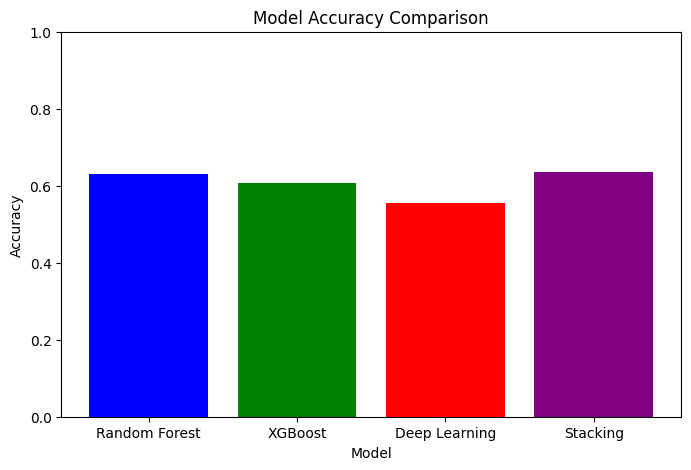


Classification Report (Stacking Model):
              precision    recall  f1-score   support

           0       0.64      1.00      0.78      5038
           1       0.35      0.00      0.00      2884

    accuracy                           0.64      7922
   macro avg       0.49      0.50      0.39      7922
weighted avg       0.53      0.64      0.50      7922



In [ ]:
# Generate a comparison plot
model_names = ['Random Forest', 'XGBoost', 'Deep Learning', 'Stacking']
accuracies = [rf_acc, xgb_acc, dnn_acc, stk_acc]

plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracies, color=['blue', 'green', 'red', 'purple'])
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)
plt.show()

print("\nClassification Report (Stacking Model):")
print(classification_report(y_test, stk_pred))
